In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import time

# load the modules specific to this project
from context import network as nw
from context import physics
from context import timemarching as tm
from context import plotter
from context import logger

plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [2]:
channel_list = ['blue','red']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}

### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [3]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
# An input layer automatically creates on node for each channel that we define
layers[0] = nw.InputLayer(N=1)
# Forward signal layer
layers[1] = nw.HiddenLayer(N=1, output_channel='blue',excitation_channel='blue',inhibition_channel='red')
# Inhibiting memory layer
layers[2] = nw.HiddenLayer(N=1, output_channel='red' ,excitation_channel='blue',inhibition_channel='red')
layers[3] = nw.OutputLayer(N=1) # similar to input layer

### 3. Define existing connections between layers
The weights are set in two steps. 
First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.
Second, the specific connections on the node-to-node level are specified using the node index in each layer

In [4]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
weights['inp->hd0'] = nw.connect_layers(0, 1, layers, channel='blue')
weights['hd0->hd1'] = nw.connect_layers(1, 2, layers, channel='blue')
weights['hd0->out'] = nw.connect_layers(1, 3, layers, channel='blue')
# Backwards connection from the memory
weights['hd1->hd0'] = nw.connect_layers(2, 1, layers, channel='red')

# Define the specific node-to-node connections in the weight matrices
low_weight =  1.0 # 0.02
# The syntax is connect_nodes(from_node, to_node, channel=label, weight=value in weight matrix)
self_inhib = 1.0
# Draw a ring network with Nring nodes (Nring defined above)

# Input to first ring layer node
weights['inp->hd0'].connect_nodes(0 ,0,weight=1.0) # channels['blue']=1
#weights['inp->hd0'].connect_nodes(channels['red'] ,0, channel='red', weight=1.0) # channels['blue']=1
# Hidden layer connections
weights['hd0->hd1'].connect_nodes(0 ,0 , weight=self_inhib) 
# Add damping connection
weights['hd1->hd0'].connect_nodes(0 ,0 , weight=self_inhib)    
# Connect to output
weights['hd0->out'].connect_nodes(0, 0, weight=0.9)

### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden or Output) and the index. To supress the printing of weight values on each connection, please supply `show_edge_labels=False`.

#### Available layouts:
**multipartite**: Standard neural network appearance. Hard to see recurrent couplings within layers.  
**circular**: Nodes drawn as a circle  
**shell**: Layers drawn as concetric circles  
**kamada_kawai**: Optimization to minimize weighted internode distance in graph  
**spring**: Spring layout which is standard in `networkx` 

#### Shell layout
This is my current favorite. It is configured to plot the input and output nodes on the outside of the hidden layer circle, in a combined outer concentric circle.

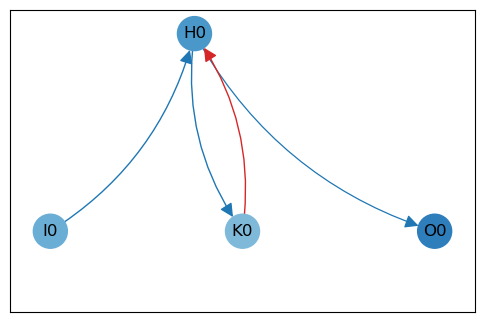

{'K0': array([0., 0.]),
 'H0': array([-0.16666669,  0.28867513]),
 'I0': array([-6.66666687e-01, -5.82818522e-08]),
 'O0': array([6.66666687e-01, 1.16563704e-07])}

In [5]:
plotter.visualize_network(layers, weights, layout='shell',
                          show_edge_labels=False,#shell_order=[1,[2,3],[0,4]],
                          savefig=True)

### 5. Specify the physics of the nodes
Before running any simulations, we need to specify the input currents and the physics of the hidden layer nodes. Parameters can either be specified directly or coupled from the `physics` module. 

In [6]:
# Specify two types of devices for the hidden layer
# 1. Propagator (standard parameters)
propagator = physics.Device('../parameters/device_parameters.txt')

propagator.print_parameter('Rstore')
# 2. Memory (modify the parameters)
memory = physics.Device('../parameters/device_parameters_memory.txt')
memory.set_parameter('Rstore', 2e8)
memory.set_parameter('Cstore',0.7e-15) # TRY THIS TO SEE WHAT CHANGES
memory.print_parameter('Rstore')

The parameter Rstore=2000000.0 Ohm
The parameter Rstore=200000000.0 Ohm


In [7]:
# Specify the internal dynamics by supplying the RC constants to the hidden layer (six parameters)
layers[1].assign_device(propagator)
layers[2].assign_device(memory)
# Tweak the threshold voltage
Vthres=1.0
layers[1].Vthres=Vthres
layers[2].Vthres=Vthres

# Calculate the unity_coeff to scale the weights accordingly
unity_coeff, Imax = propagator.inverse_gain_coefficient(propagator.eta_ABC, Vthres)
print(f'Unity coupling coefficient calculated as unity_coeff={unity_coeff:.4f}')
print(f'Imax is found to be {Imax} nA')

Unity coupling coefficient calculated as unity_coeff=0.0254
Imax is found to be 374.995312558593 nA


In [8]:
# Specify an exciting current square pulse and a constant inhibition
# Pulse train of 1 ns pulses
t_blue = [(5.0,15.0)]#, (255.0,455.0)] # 

# Use the square pulse function and specify which node in the input layer gets which pulse
layers[0].set_input_vector_func(func_handle=physics.square_pulse, func_args=(t_blue, 1.0*Imax))

Produce Bode plots to determine what our frequency cutoff will be

In [9]:
# Setup the gain function
eigvals = propagator.setup_gain(propagator.gammas)

# The eigenvalues
print('System eigenvalues:')
k=0
for l in eigvals :
    print(f'eig[{k}]={l:.2f} ns^-1 ')
    k+=1
# Regarding the eigenvalues, eig[0]=-25.81 ns^-1, eig[1]=-5.00 ns^-1, eig[2]=-0.19 ns^-1
# eig[1] regards the charge collecting subsystem, this is their RC constant
# eig[0] regards the exchange between the collectors and the storage, I believe. For A33=20 it's zero
# eig[2] regards the time scale of the storage unit, the longest timescale in the system.
    
# PUT THIS IN THE PLOTTER MODULE
import numpy as np
# Visualize the response function 
Ns = 100
# Units are already in GHz so this creates a space from 1 MHz to 10 GHz
s_exp = np.linspace(-5,1,Ns)
s = 1j*10**s_exp

# Sample the gain function
G11, _ = propagator.gain(s,eigvals,propagator.gammas)

mag_G11 = np.absolute(G11) / np.absolute(G11[0])
arg_G11 = np.angle(G11)

mag_G11_dB = 20*np.log10(mag_G11)

System eigenvalues:
eig[0]=-25.24 ns^-1 
eig[1]=-5.00 ns^-1 
eig[2]=-0.59 ns^-1 
eig[3]=-5.00 ns^-1 


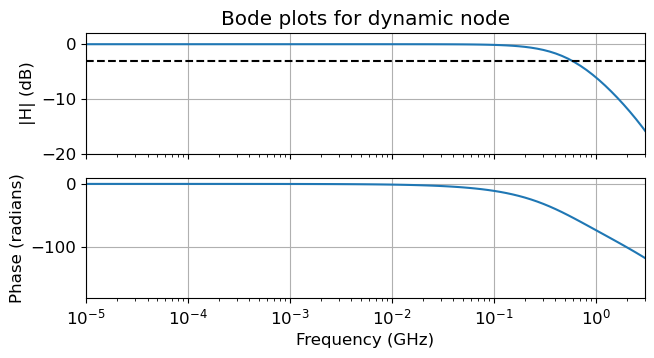

In [10]:
# Produce Bode plots of the results
# Define parameters
my_dpi = 300
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Figure sizes
inchmm = 25.4
nature_single = 89.0 / 25.4
nature_double = 183.0 / 25.4
nature_full = 247.0 / 25.4

# Plot options
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(nature_double,nature_single),sharex=True)

f_min = abs(s[0])
plot_f_max = 3.0 # GHz

ax1.plot(abs(s),mag_G11_dB)
ax1.plot([f_min,plot_f_max],[-3,-3],'k--')
ax1.grid('True')
ax1.set_xscale('log')
ax1.set_title('Bode plots for dynamic node')
#ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('|G11|/|G11[0]| (dB)')
ax1.set_ylabel('|H| (dB)')
ax1.set_xlim(f_min,plot_f_max)
ax1.set_ylim(-20,2)

ax2.plot(abs(s),arg_G11*180/np.pi)
ax2.grid('True')
#ax2.set_xscale('log')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('Phase (radians)')
ax2.set_ylim(-180,10)

plt.show()

### 6. Evolve in time

In [11]:
# Start time t, end time T
t = 0.0
T = 100.0 # ns
# To sample result over a fixed time-step, use savetime
savestep = 1.0
savetime = savestep
# These parameters are used to determine an appropriate time step each update
dtmax = 0.1 # ns 
dVmax = 0.001 # V

nw.reset(layers)
# Create a log over the dynamic data
time_log = logger.Logger(layers,channels) # might need some flags

start = time.time()

while t < T:
    # evolve by calculating derivatives, provides dt
    dt = tm.evolve(t, layers, dVmax, dtmax )

    # update with explicit Euler using dt
    # supplying the unity_coeff here to scale the weights
    tm.update(dt, t, layers, weights, unity_coeff)
    
    t += dt
    # Log the progress
    if t > savetime :
        # Put log update here to have (more or less) fixed sample rate
        # Now this is only to check progress
        print(f'Time at t={t} ns') 
        savetime += savestep
    
    time_log.add_tstep(t, layers, unity_coeff)

end = time.time()
print('Time used:',end-start)

# This is a large pandas data frame of all system variables
result = time_log.get_timelog()

Time at t=1.0999999999999999 ns
Time at t=2.0000000000000004 ns
Time at t=3.060658478931133 ns
Time at t=4.01953334135911 ns
Time at t=5.050491657253949 ns
Time at t=6.000249059489522 ns
Time at t=7.003782138602256 ns
Time at t=8.004138853086948 ns
Time at t=9.004741545997172 ns
Time at t=10.001989764560394 ns
Time at t=11.003723567682206 ns
Time at t=12.008793353384844 ns
Time at t=13.005115038447784 ns
Time at t=14.031316901551401 ns
Time at t=15.074153075698396 ns
Time at t=16.000481244803797 ns
Time at t=17.004080761155073 ns
Time at t=18.0001433588145 ns
Time at t=19.003425210133315 ns
Time at t=20.019319788981715 ns
Time at t=21.009974878834534 ns
Time at t=22.000611579623992 ns
Time at t=23.01160170849796 ns
Time at t=24.01108401520568 ns
Time at t=25.00403186308152 ns
Time at t=26.036576162877214 ns
Time at t=27.016686299778257 ns
Time at t=28.047414628577926 ns
Time at t=29.001049880769223 ns
Time at t=30.013513135460595 ns
Time at t=31.01351313546061 ns
Time at t=32.013513135

### 7. Visualize results
Plot results specific to certain nodes

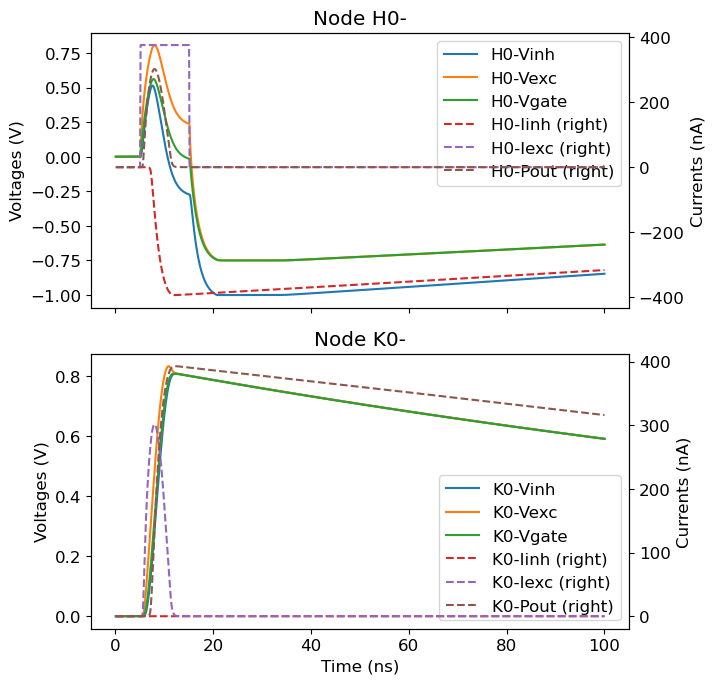

In [12]:
#nodes = ['H0','H1','H2','H3','H4']

nodes = ['H0','K0']
plotter.plot_nodes(result, nodes, onecolumn=True)

For this system it's quite elegant to use the `plot_chainlist` function, taking as arguments a graph object, the source node (I1 for blue) and a target node (O1 for blue)

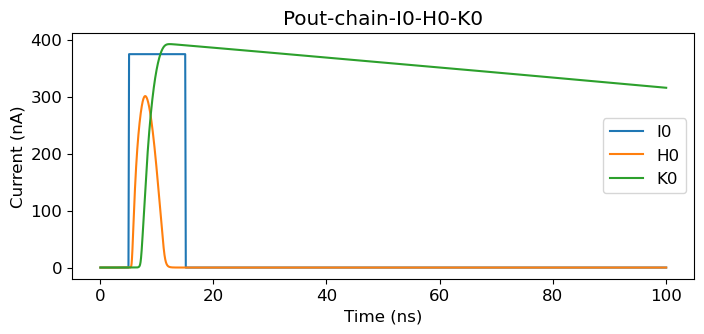

In [13]:
# Variable G contains a graph object descibing the network
G = plotter.retrieve_G(layers, weights)
plotter.plot_chainlist(result,G,'I0','K0')

Plot specific attributes

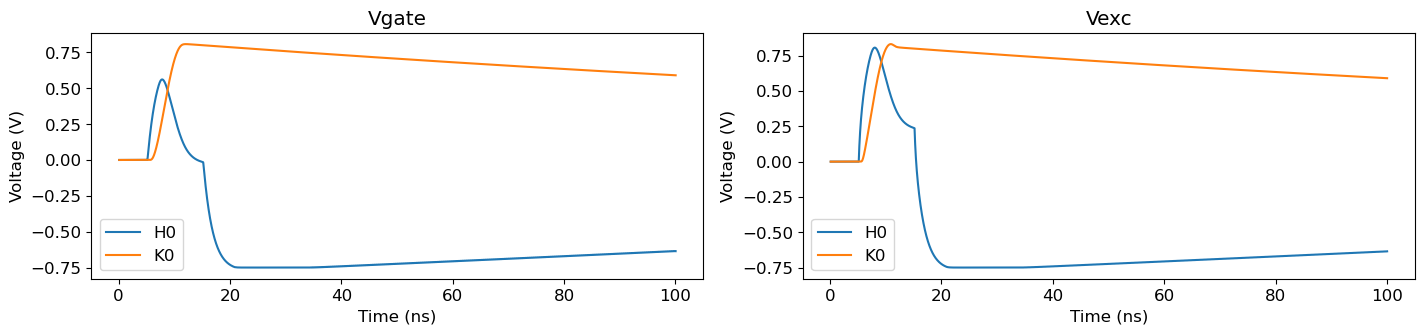

In [14]:
attr_list = ['Vgate','Vexc']
plotter.plot_attributes(result, attr_list)

We can be totally specific if we want. First we list the available columns to choose from

In [ ]:
print(result.columns)

In [ ]:
plotter.visualize_dynamic_result(result, ['H0-Iout','H0-Pout'])

We can also look in depth at the physical aspects of the node, like transistor IV and the LED efficiency.

In [ ]:
plotter.visualize_transistor(propagator.transistorIV_example())

In [ ]:
plotter.visualize_LED_efficiency(propagator.eta_example(propagator.eta_ABC))

In [ ]:
tau_memory = memory.calc_tau_gate() # 0.056 ns
tau_propagator = propagator.calc_tau_gate()
gammas_memory = memory.calc_gammas()
gammas_propagator = propagator.calc_gammas()